In [4]:
# install.packages("forecast")
library(forecast)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# chapter6 : 전통적 시계열 모형

## AR 모형

### 수요 예측 데이터 불러오기

In [12]:
demand <- read.csv("/content/sample_data/Daily Demand Forecasting Orders.csv", check.names = FALSE)
head(demand)

,,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
3,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
4,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
5,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
6,5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


### ACF, PACF 그려서 모형을 정의

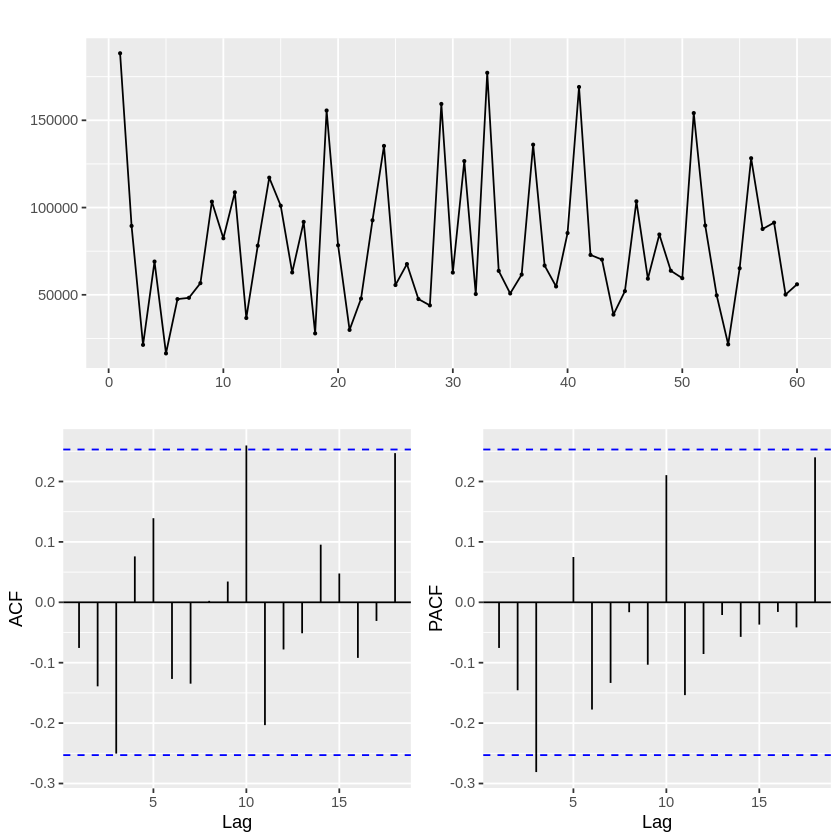

In [13]:
target_data= demand['Banking orders (2)']
forecast::ggtsdisplay(target_data)

PACF를 보면, Lag 4 부터 신뢰구간 안에 들어가는 것을 확인할 수 있다. 따라서 AR(3) 모형이라 말할 수 있다.

### ar 함수를 사용해서 정말로 AR(3) 모형인지 확인하기

In [14]:
fit <- ar(demand[["Banking orders (2)"]], method = "mle")
fit


Call:
ar(x = demand[["Banking orders (2)"]], method = "mle")

Coefficients:
      1        2        3  
-0.1360  -0.2014  -0.3175  

Order selected 3  sigma^2 estimated as  1.414e+09

ar 함수는 아카이케 정보 기준(AIC)에 따라 차수를 결정하는데, AIC 값이 작은 모델을 선호한다. selected 3를 보면, 함수 결과도 AR(3) 모형을 선택한 것으로 드러났다.

### arima 함수를 사용해서 차수를 직접 부여하기

In [15]:
est <- arima(x = demand[["Banking orders (2)"]],
             order = c(3, 0, 0))
est


Call:
arima(x = demand[["Banking orders (2)"]], order = c(3, 0, 0))

Coefficients:
          ar1      ar2      ar3  intercept
      -0.1358  -0.2013  -0.3176  79075.350
s.e.   0.1299   0.1289   0.1296   2981.124

sigma^2 estimated as 1.414e+09:  log likelihood = -717.42,  aic = 1444.83

### t-1 항의 계수를 0으로 만들기

fixed 파라미터에 전달되는 벡터 값에 NA 대신 0을 넣음으로써 해당 항의 계수를 0으로 만든다.

In [16]:
est.1 <- arima(x = demand[["Banking orders (2)"]],
               order = c(3, 0, 0),
               fixed = c(0, NA, NA, NA))
est.1

Warning message in arima(x = demand[["Banking orders (2)"]], order = c(3, 0, 0), :
“some AR parameters were fixed: setting transform.pars = FALSE”



Call:
arima(x = demand[["Banking orders (2)"]], order = c(3, 0, 0), fixed = c(0, NA, 
    NA, NA))

Coefficients:
      ar1      ar2      ar3  intercept
        0  -0.1831  -0.3031  79190.705
s.e.    0   0.1289   0.1298   3345.253

sigma^2 estimated as 1.44e+09:  log likelihood = -717.96,  aic = 1443.91

### 모델 성능 검사

acf() 함수를 사용해서 잔차 그래프 그리기

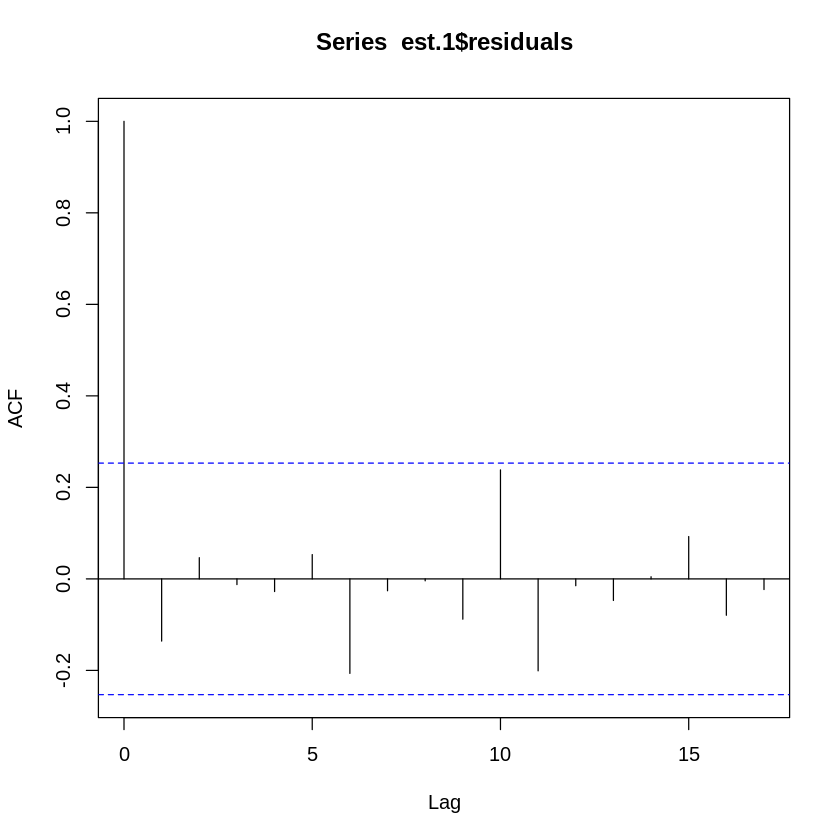

In [24]:
acf(est.1$residuals)

Lag 0을 제외하고, 어느 것도 신뢰구간을 넘지 않았다. Lag 0은 항상 신뢰구간을 넘는데, 그 이유는 Lag 0에서의 자기상관 계수가 항상 1이기 때문이다.

#### 륭-박스 검정
* H0 : 데이터가 일련의 상관관계를 나타내지 않는다.
* H1 : 데이터가 일련의 상관관계를 나타낸다.

In [25]:
Box.test(est.1$residuals, lag = 10, type = "Ljung", fitdf = 3)


	Box-Ljung test

data:  est.1$residuals
X-squared = 9.3261, df = 7, p-value = 0.2301


 p-value > 0.05이므로, H0를 기각할 수 없다. 따라서 데이터 간의 상관관계가 없다.

### 예측 그래프 그리기

실선은 원본 시계열, 색으로 된 선은 적합된 시계열

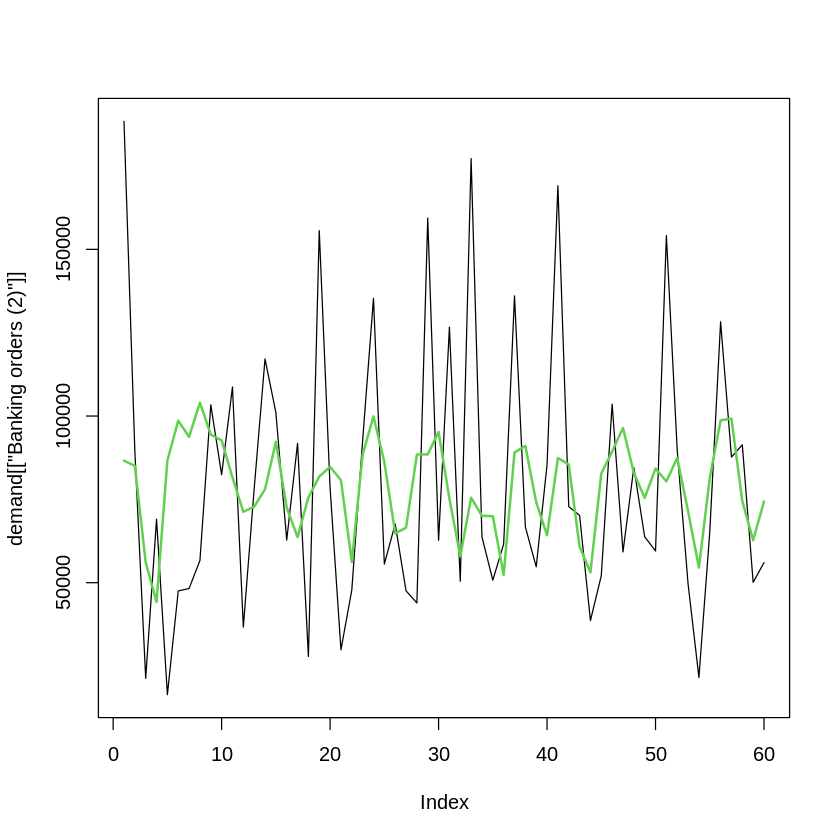

In [19]:
plot(demand[["Banking orders (2)"]], type = "l")
lines(fitted(est.1), col = 3, lwd = 2)

### 예측하기

미래 값에 대한 예측을 수행

In [20]:
fitted(est.1)

A Time Series:
 [1]  86598.68  85060.12  56078.02  44204.85  86677.79  98592.36  93759.43
 [8] 104018.70  94452.02  92688.13  81589.53  71273.26  72812.24  78022.74
[15]  92261.97  72556.50  63686.50  75567.32  81853.01  84770.94  80750.12
[22]  56174.38  88467.93  99888.38  86233.48  64818.36  66502.35  88465.38
[29]  88490.42  95234.16  75195.37  57901.02  75491.94  70077.16  69954.48
[36]  52311.71  89092.00  91029.77  74115.30  64240.01  87434.62  85459.10
[43]  60853.28  53105.38  82763.66  89343.12  96438.65  82934.58  75457.17
[50]  84257.72  80386.23  87465.75  71429.63  54546.83  81414.68  98697.42
[57]  99217.05  74444.42  62755.17  74379.35

### 분산 구하기

In [21]:
residuals(est.1)

A Time Series:
 [1] 101812.317   4400.877 -34773.015  24849.150 -70266.785 -51070.356
 [7] -45490.428 -47353.697   8923.976 -10293.126  27129.474 -34580.264
[13]   5340.763  39114.256   8786.027  -9757.499  28097.501 -47694.317
[19]  73763.985  -6392.939 -50876.117  -8381.380   4233.067  35425.624
[25] -30649.478   2798.643 -18939.355 -44535.383  70882.577 -32502.156
[31]  51436.630  -7468.021 101737.056  -6378.160 -19191.484   9281.289
[37]  46942.999 -24284.767 -19343.299  21137.990  81653.384 -12619.103
[43]   9337.717 -14459.381 -30651.661  14223.883 -37207.647   1623.416
[49] -11679.171 -24744.719  73757.765   2238.247 -21785.630 -32973.831
[55] -16215.683  29571.582 -11509.053  16922.583 -12643.167 -18364.348

## MA 모형

### ACF 그려서 차수 결정하기

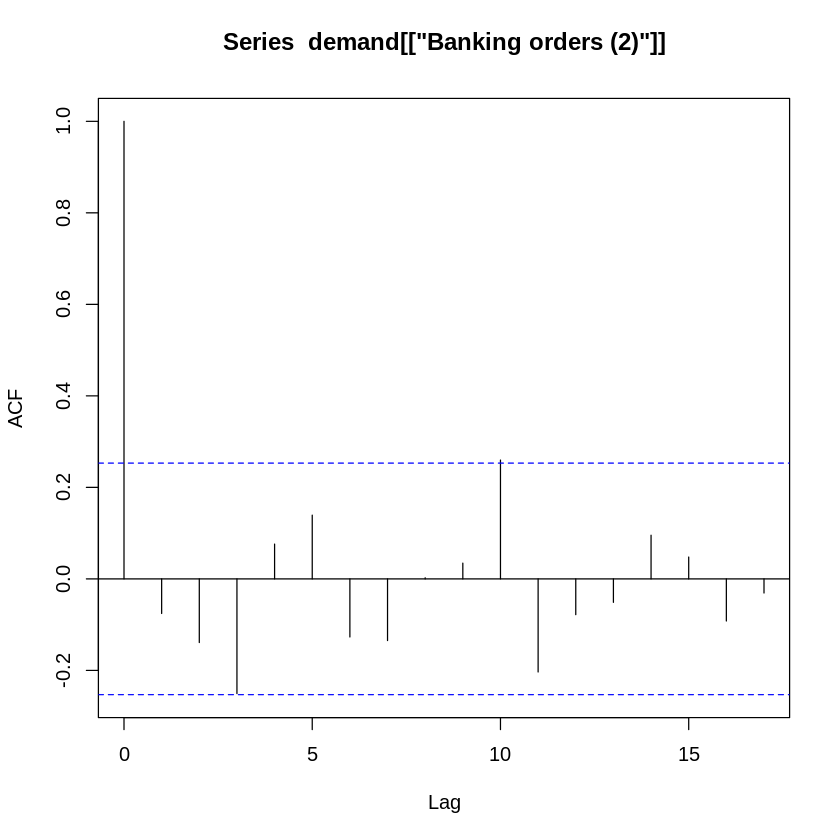

In [22]:
acf(demand[["Banking orders (2)"]])

Lag 3과 9에서 신뢰구간의 경계를 넘는 것으로 판단된다.

In [23]:
ma.est <- arima(x = demand[["Banking orders (2)"]],
                order = c(0, 0, 9),
                fixed = c(0, 0, NA, rep(0, 5), NA, NA))
ma.est


Call:
arima(x = demand[["Banking orders (2)"]], order = c(0, 0, 9), fixed = c(0, 0, 
    NA, rep(0, 5), NA, NA))

Coefficients:
      ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8      ma9  intercept
        0    0  -0.4725    0    0    0    0    0  -0.0120  79689.809
s.e.    0    0   0.1459    0    0    0    0    0   0.1444   2674.593

sigma^2 estimated as 1.4e+09:  log likelihood = -717.31,  aic = 1442.61

### 모델 성능 검사
* H0 : 잔차 데이터 간의 상관관계가 없다.
* H1 : 잔차 데이터 간의 상관관계가 있다.

In [26]:
Box.test(ma.est$residuals, lag = 10, type = "Ljung", fitdf = 3)


	Box-Ljung test

data:  ma.est$residuals
X-squared = 7.6516, df = 7, p-value = 0.3643


p-value > 0.05이므로, 귀무가설을 기각할 수 없다, 즉, 잔차 데이터 간의 상관관계가 없다고 할 수 있다.

### 예측값 구하기

In [27]:
fitted(ma.est, h=1)

A Time Series:
 [1]  90116.64  80626.91  74090.45  38321.61  74734.77 101153.20  65930.90
 [8] 106351.80 104138.05  86938.99 102868.16  80502.02  81466.01  77619.15
[15] 100984.93  81463.10  61622.54  79660.81  88563.91  65370.99 104679.89
[22]  48047.39  73070.29 115034.16  80034.03  70052.29  70728.85  90437.86
[29]  80684.44  91533.59 101668.18  42273.27  93055.40  68187.65  75863.50
[36]  40195.15  82368.91  90605.60  69924.83  54032.55  90866.20  85839.41
[43]  64932.70  43030.64  85575.32  76561.14  82047.95  95683.35  66553.13
[50]  89532.20  85102.64  80937.97  93926.74  47468.84  75223.67 100887.60
[57]  92059.32  84459.85  67112.16  80917.23

주의 : MA(q) 모형은 q 시점 이후의 값을 올바르게 예측하기 힘들다. AR(p) 모형도 마찬가지이다. 만약 먼 시점의 값을 예측하고 싶다면, 차수를 높게 잡아서 더 복잡한 모델을 사용하거나 다른 방법을 찾아보아야 한다.

## ARIMA 모형
* 단순히 AR과 MA 모형을 모두 포함한다면, ARMA 모형이다.
* ARMA 모형에서 추세의 제거 및 시계열을 정상화하는 차분까지 고려하는 모형이 바로 ARIMA 모형이다.

### 시계열 데이터 생성

In [28]:
set.seed(1017)
y <- arima.sim(n = 1000, list(ar = 0.2, ma = -0.7))

### 시계열 그림, ACF, PACF 확인

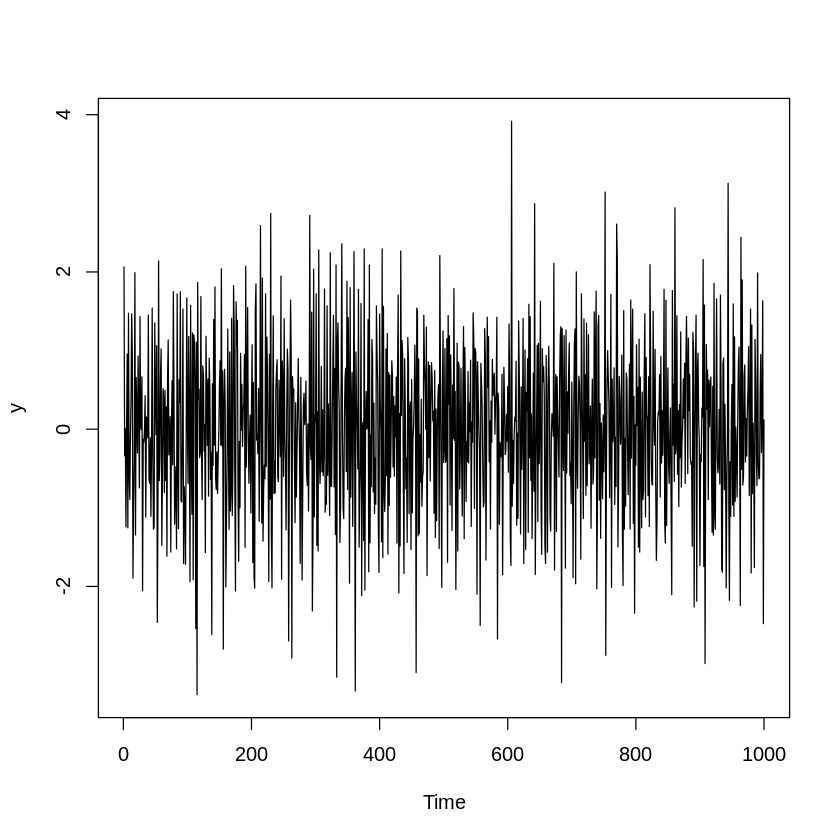

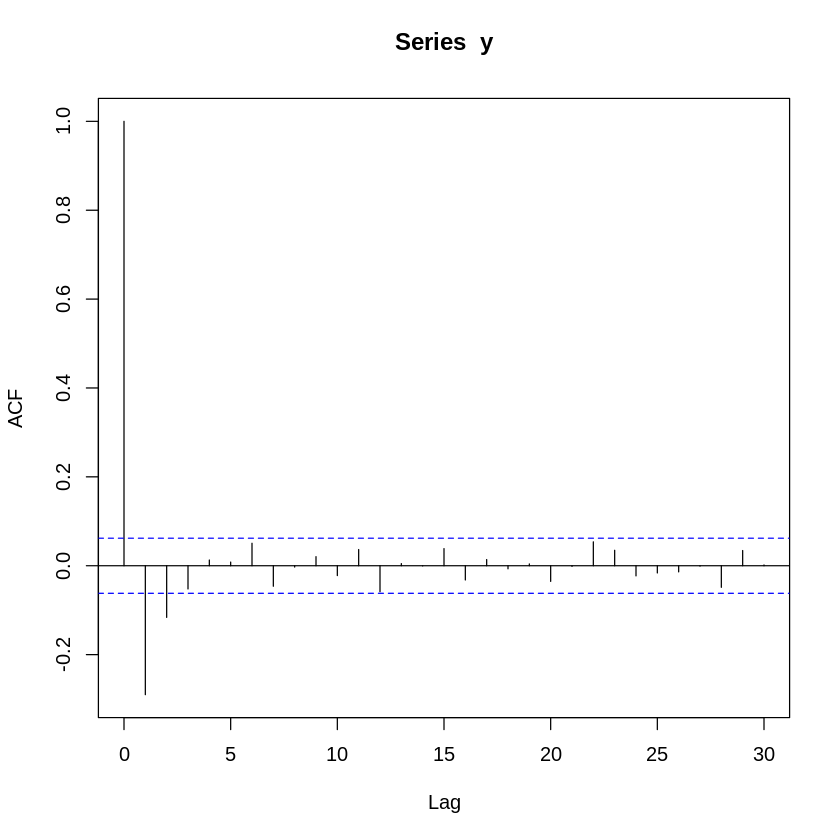

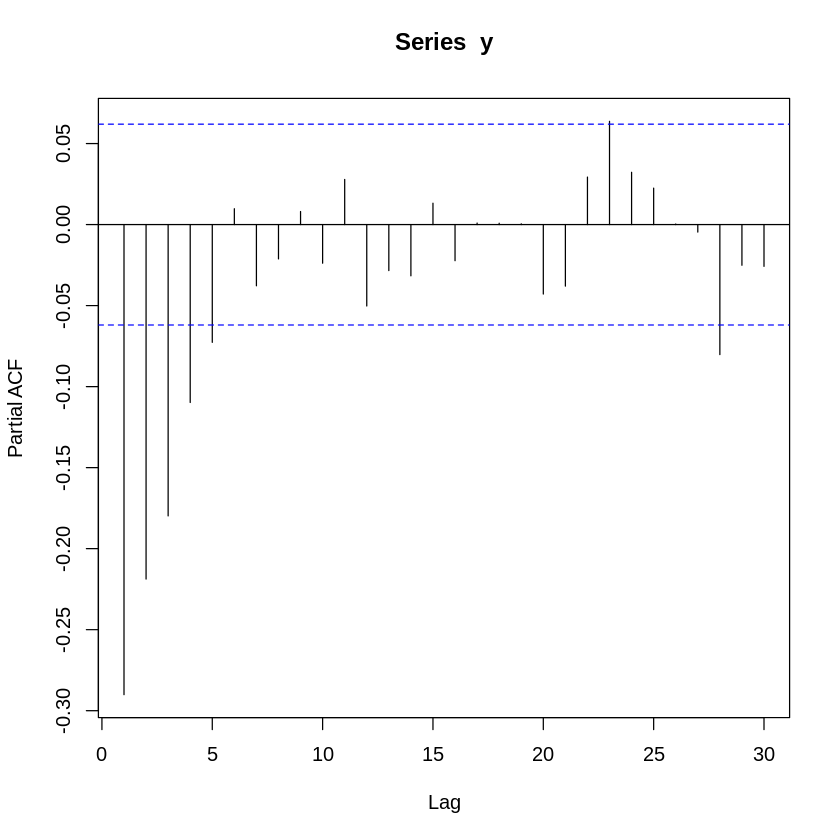

In [29]:
plot(y)
acf(y)
pacf(y)

### ARMA(1,1)에 적합시켰을 때의 ACF와 PACF

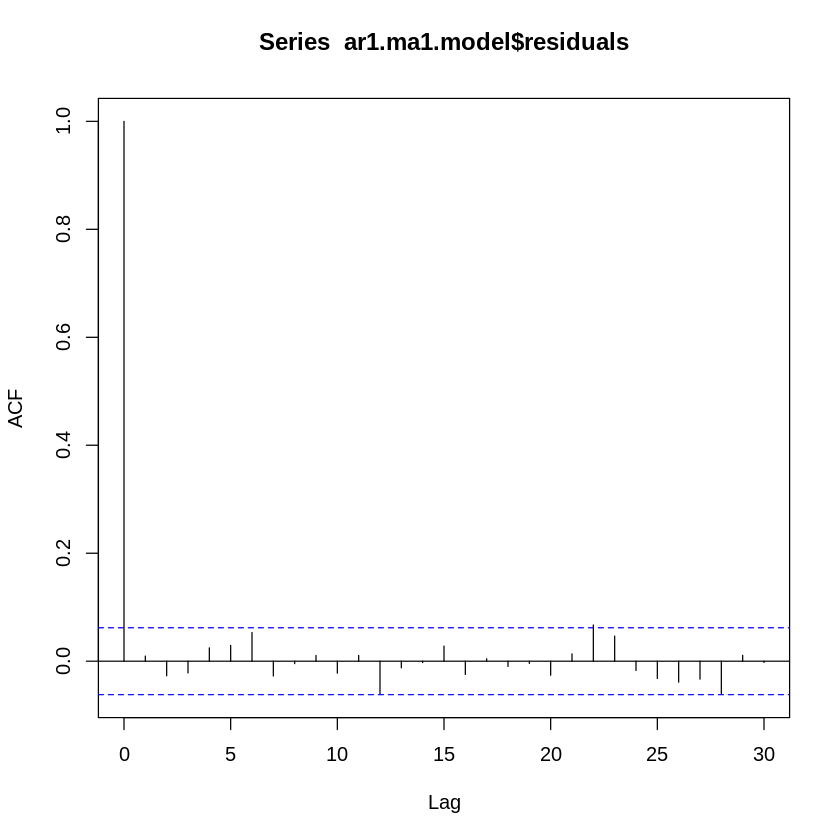

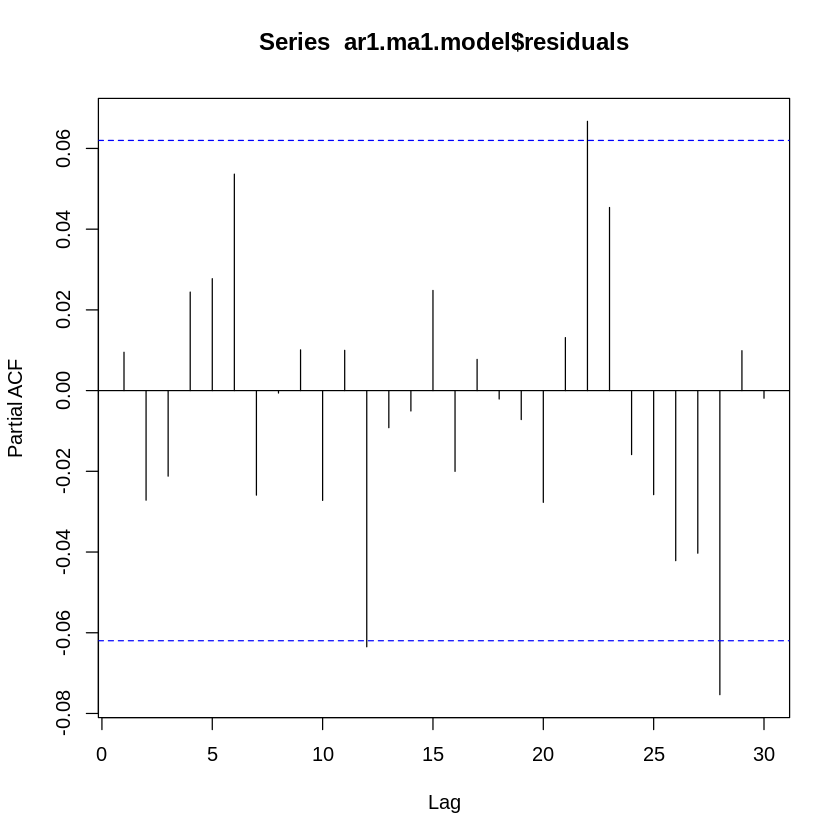

In [30]:
ar1.ma1.model <- Arima(y, order = c(1, 0, 1))
acf(ar1.ma1.model$residuals)
pacf(ar1.ma1.model$residuals)

### ARMA(2,1)

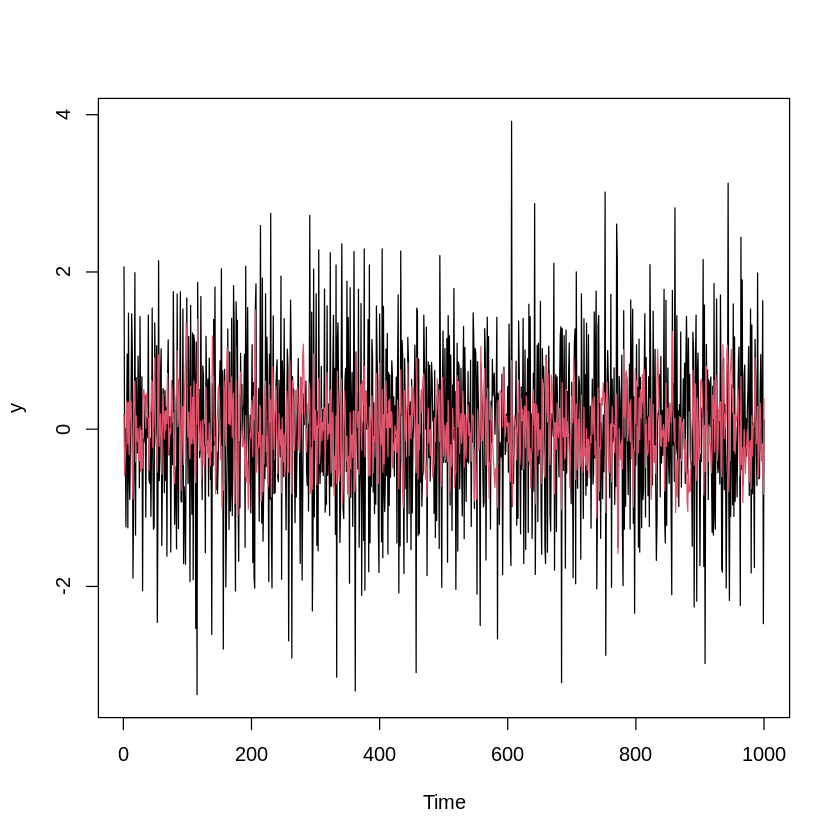

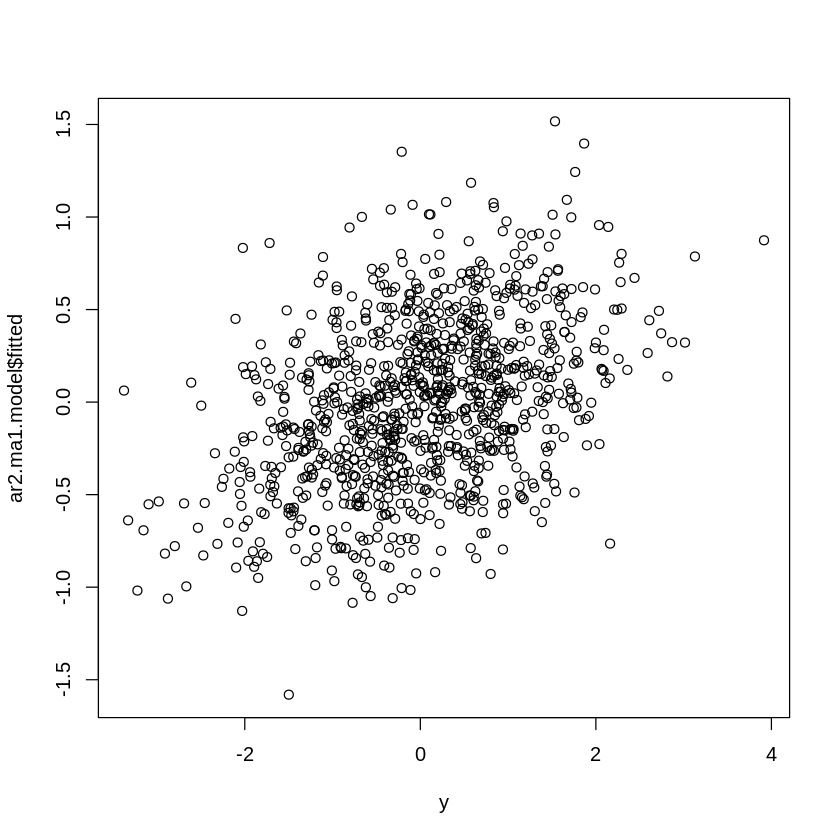

In [31]:
ar2.ma1.model <- Arima(y, order = c(2, 0, 1))
plot(y, type = "l")
lines(ar2.ma1.model$fitted, col = 2)
plot(y, ar2.ma1.model$fitted)

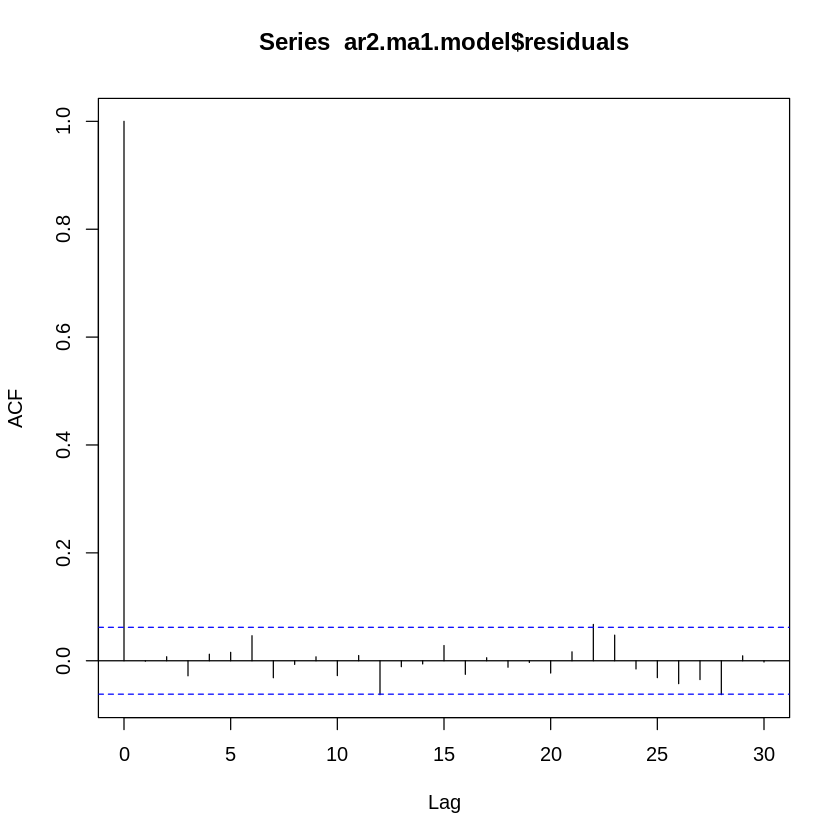

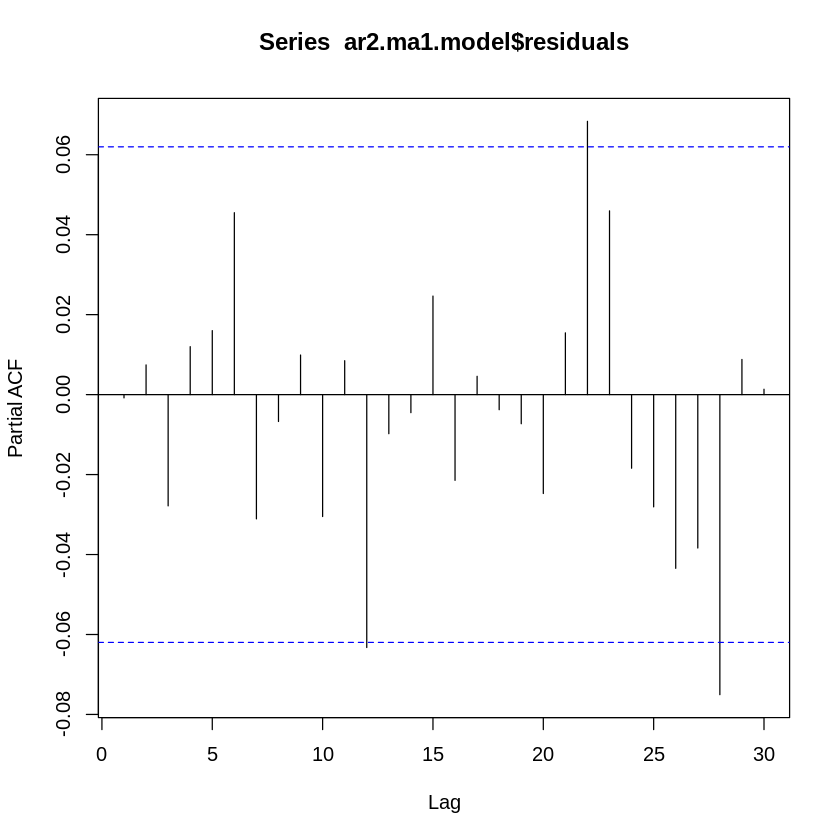

In [32]:
acf(ar2.ma1.model$residuals)
pacf(ar2.ma1.model$residuals)

### ARMA(2,2)

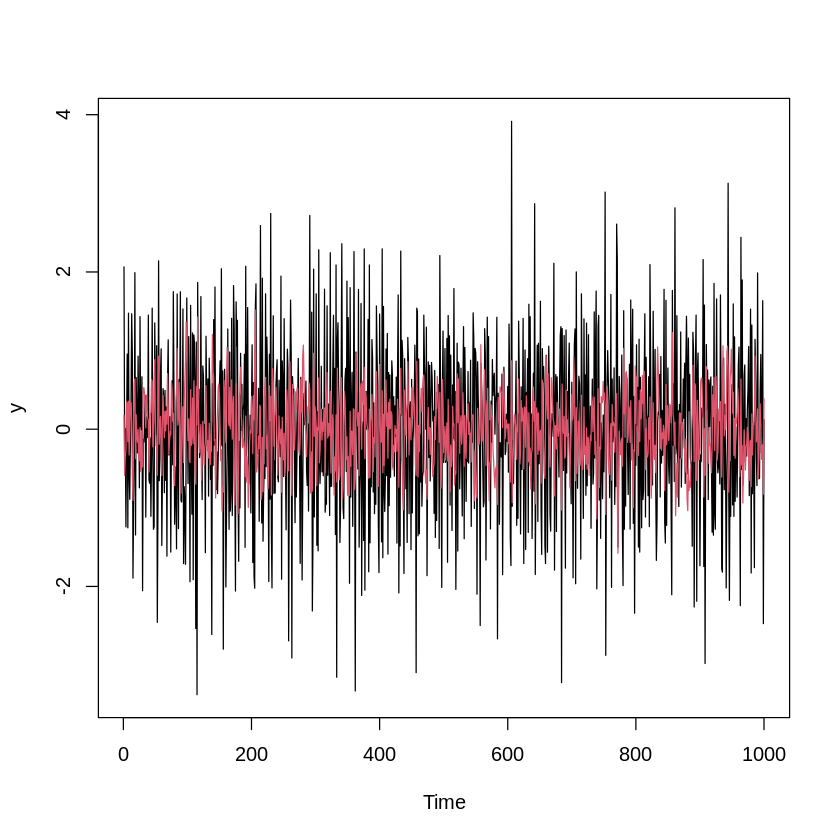

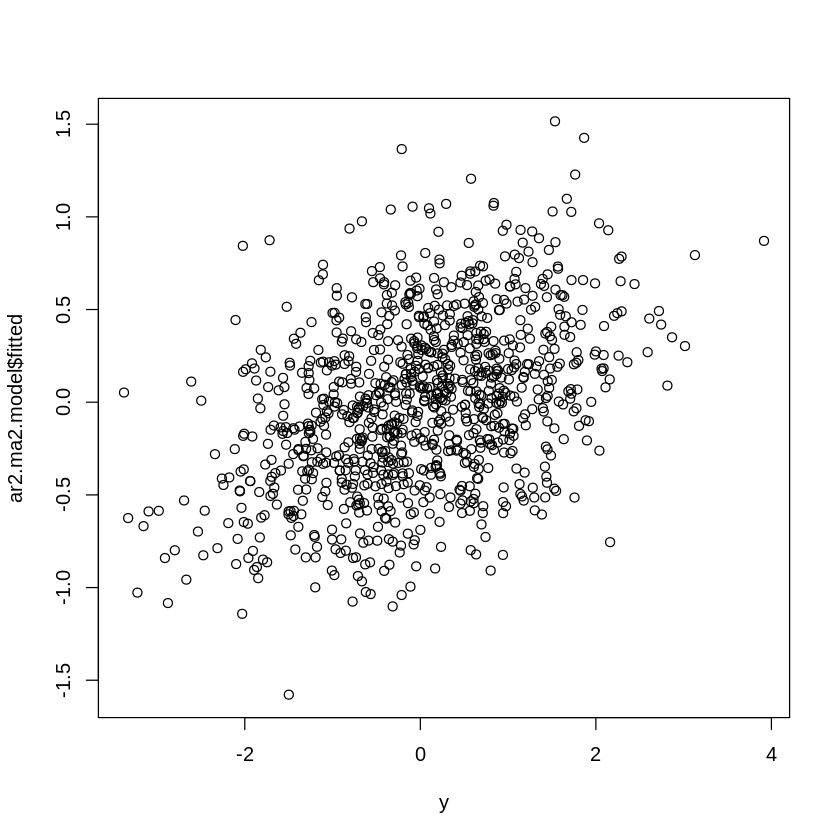

In [33]:
ar2.ma2.model <- Arima(y, order = c(2, 0, 2))
plot(y, type = "l")
lines(ar2.ma2.model$fitted, col = 2)
plot(y, ar2.ma2.model$fitted)

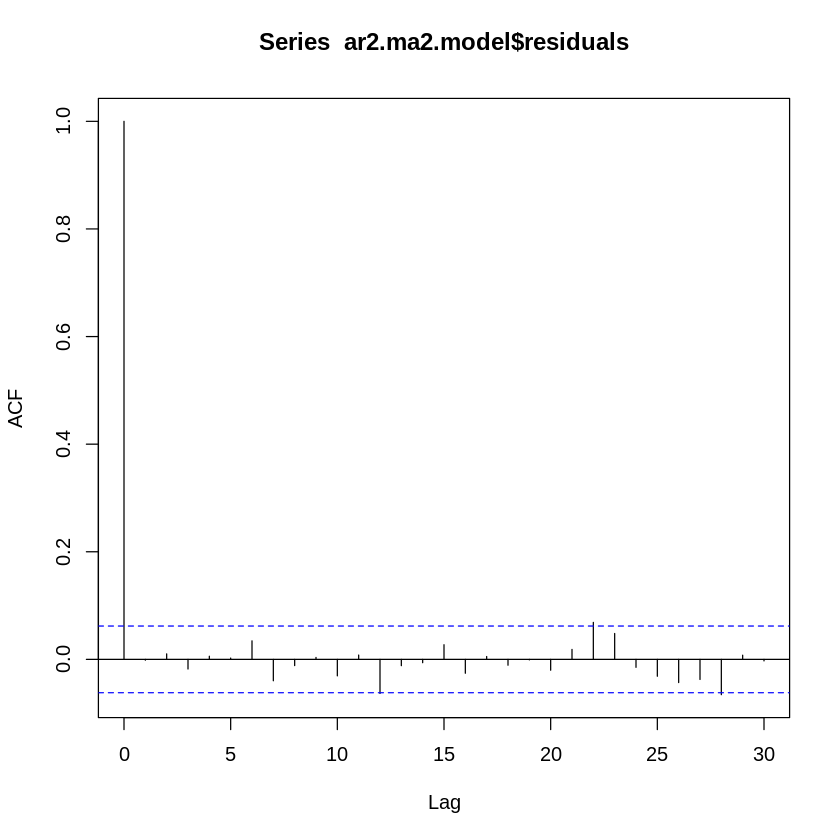

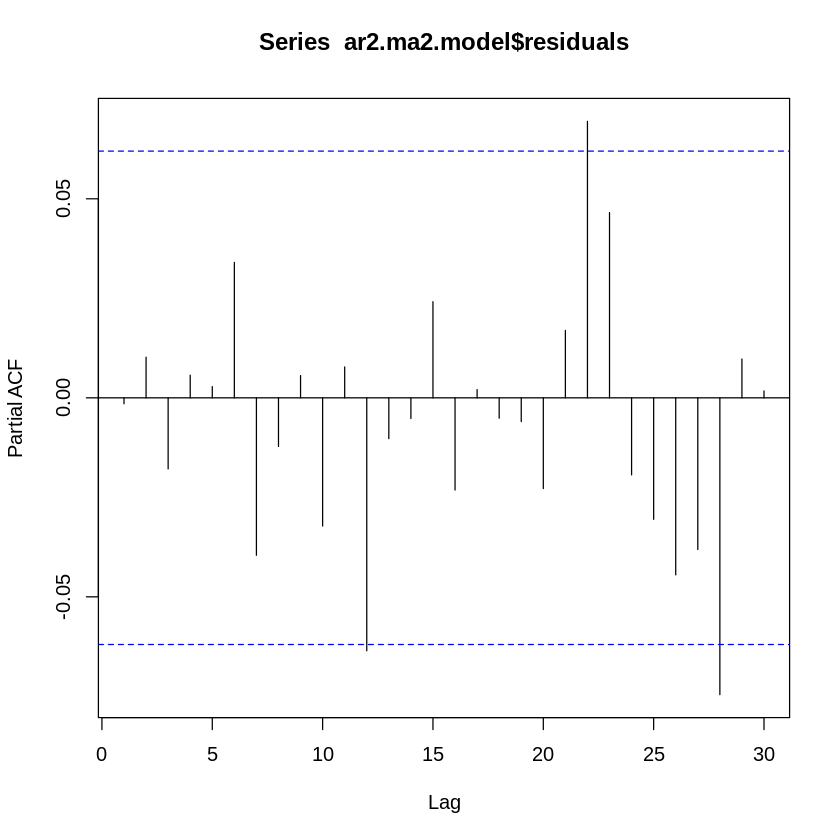

In [34]:
acf(ar2.ma2.model$residuals)
pacf(ar2.ma2.model$residuals)

### ARIMA(2,1,2)

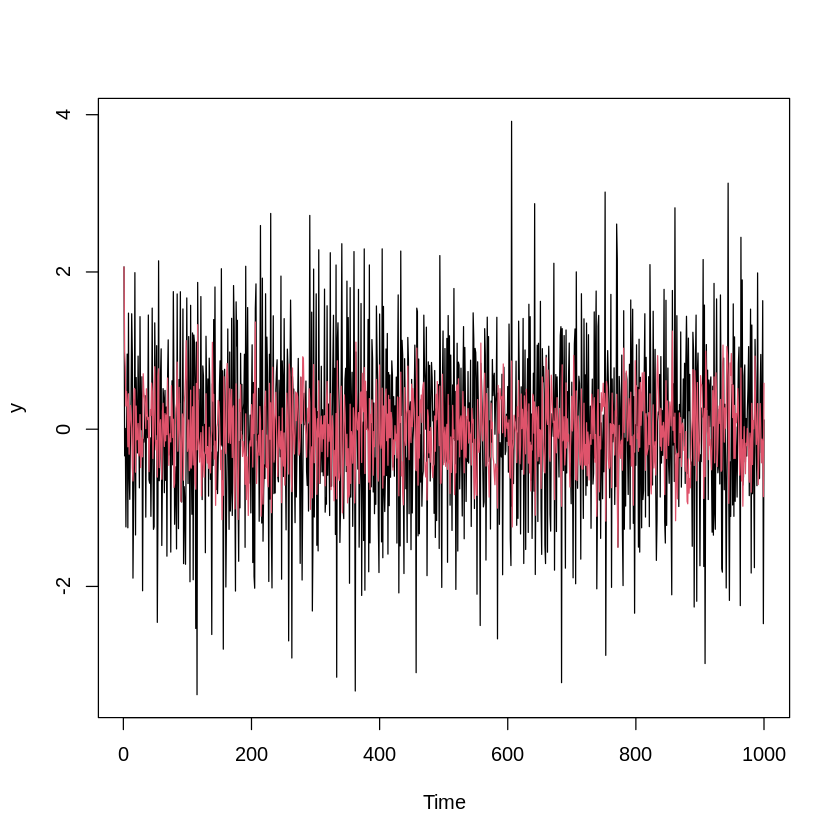

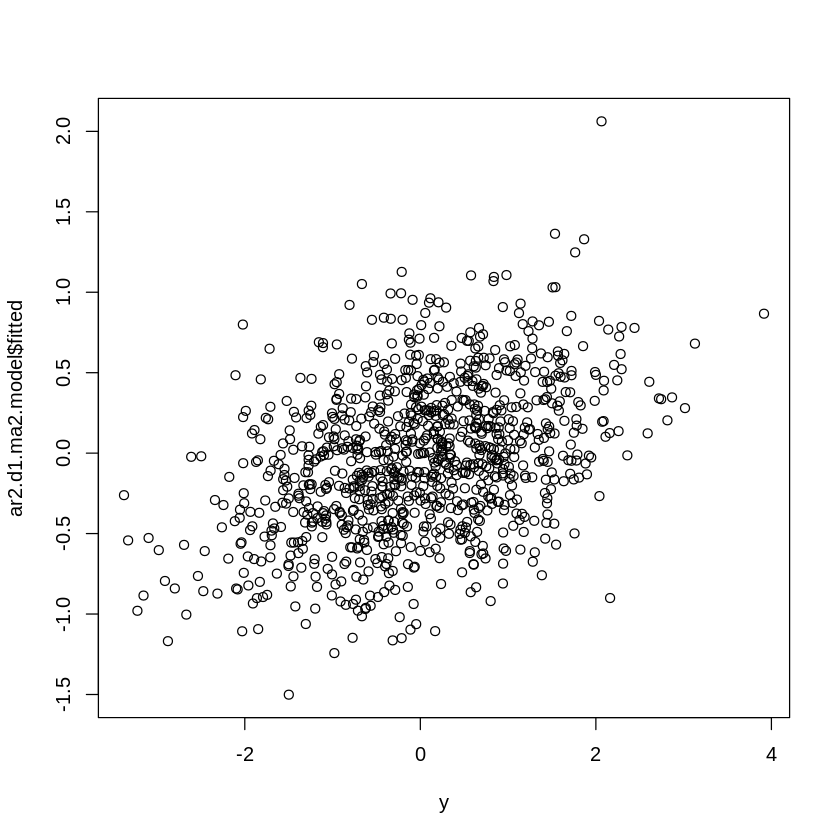

In [35]:
ar2.d1.ma2.model <- Arima(y, order = c(2, 1, 2))
plot(y, type = "l")
lines(ar2.d1.ma2.model$fitted, col = 2)
plot(y, ar2.d1.ma2.model$fitted)

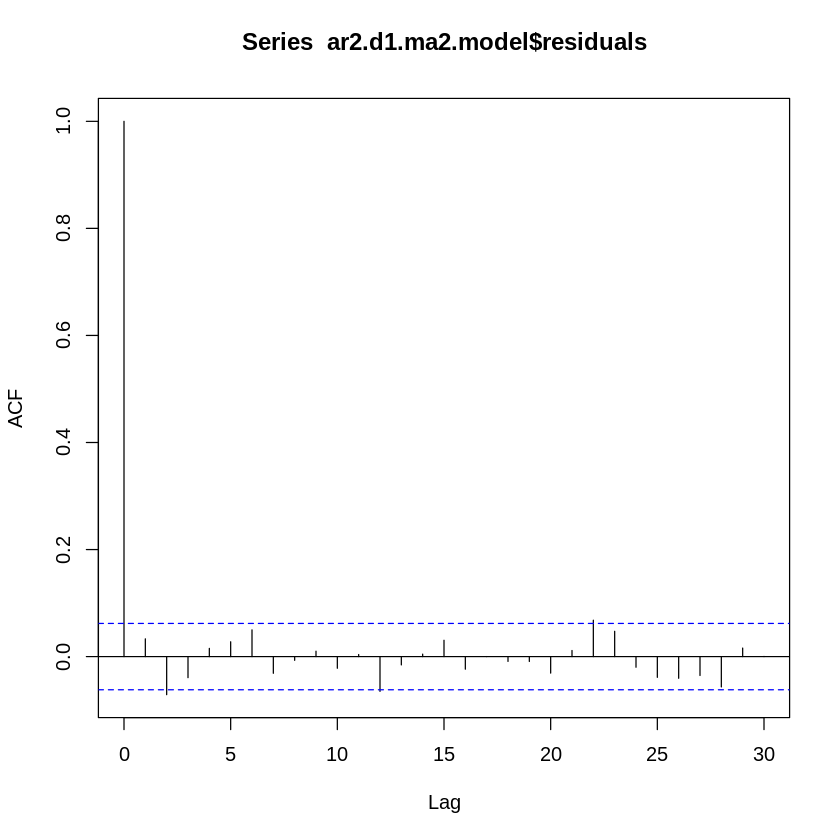

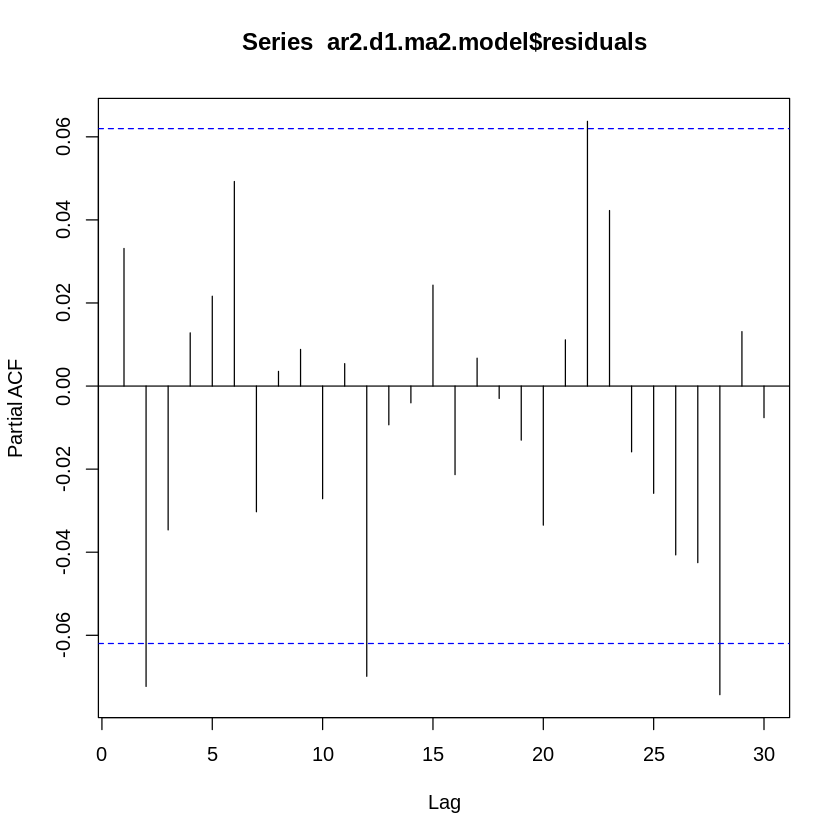

In [36]:
acf(ar2.d1.ma2.model$residuals)
pacf(ar2.d1.ma2.model$residuals)

### 실제 데이터와 적합시킨 모델 간의 상관계수  

In [37]:
cor(y, ar1.ma1.model$fitted)
cor(y, ar2.ma1.model$fitted)
cor(y, ar2.ma2.model$fitted)
cor(y, ar2.d1.ma2.model$fitted)

[1] 0.4104076

[1] 0.4122251

[1] 0.4131179

[1] 0.4051333

상관관계를 구한 결과, ARMA(2, 1) 또는 ARMA(2, 2)를 선택한다.

### 원본 데이터를 생성한 ARMA 모델의 적합 계수를 출력하고, 이를 ARIMA 모델의 적합 계수와 비교해보면 ARIMA 모델의 적합이 얼마나 좋은지 확인할 수 있다.

In [39]:
y <- arima.sim(n = 1000, list(ar = c(0.8, -0.4), ma = c(-0.7)))
ar2.ma1.model <- Arima(y, order = c(2, 0, 1))
print(ar2.ma1.model$coef)

        ar1         ar2         ma1   intercept 
 0.82455974 -0.42400597 -0.73366010 -0.00160524 


### 자동으로 모델을 적합시키는 방법
* auto.arima : grid search 방법으로 AIC를 최소화

In [40]:
est <- auto.arima(demand[["Banking orders (2)"]],
                  stepwise = FALSE, max.p = 3, max.q = 9)
est

Series: demand[["Banking orders (2)"]] 
ARIMA(0,0,3) with non-zero mean 

Coefficients:
          ma1      ma2      ma3       mean
      -0.0645  -0.1144  -0.4796  79914.783
s.e.   0.1327   0.1150   0.1915   1897.407

sigma^2 = 1.467e+09:  log likelihood = -716.71
AIC=1443.42   AICc=1444.53   BIC=1453.89

In [41]:
auto.model <- auto.arima(y)
auto.model

Series: y 
ARIMA(2,0,1) with zero mean 

Coefficients:
         ar1      ar2      ma1
      0.8245  -0.4240  -0.7336
s.e.  0.0417   0.0298   0.0401

sigma^2 = 0.9448:  log likelihood = -1389.34
AIC=2786.68   AICc=2786.72   BIC=2806.31

## 벡터자기회귀모형

* 사용하는 데이터는 그대로
* UCI 수요 정보를 살펴보고, 두 번째 열로 자체 데이터 대신 은행 주문(banking order)을 예측하는 상황을 고려한다.
* 교통 관제 부문 주문(order from the traffic control sector)의 사용도 고려한다.
* 재정 부문(fiscal sector)의 과거 주문 정보를 제공할 가능성도 고려한다.
* const 항을 사용함으로써 모델의 방정식에 절편을 포함한다.

### 예시랑 똑같이 맞추려면 12번째, 13번째 (Banking orders (2), Banking orders(3)을 가져와야 함

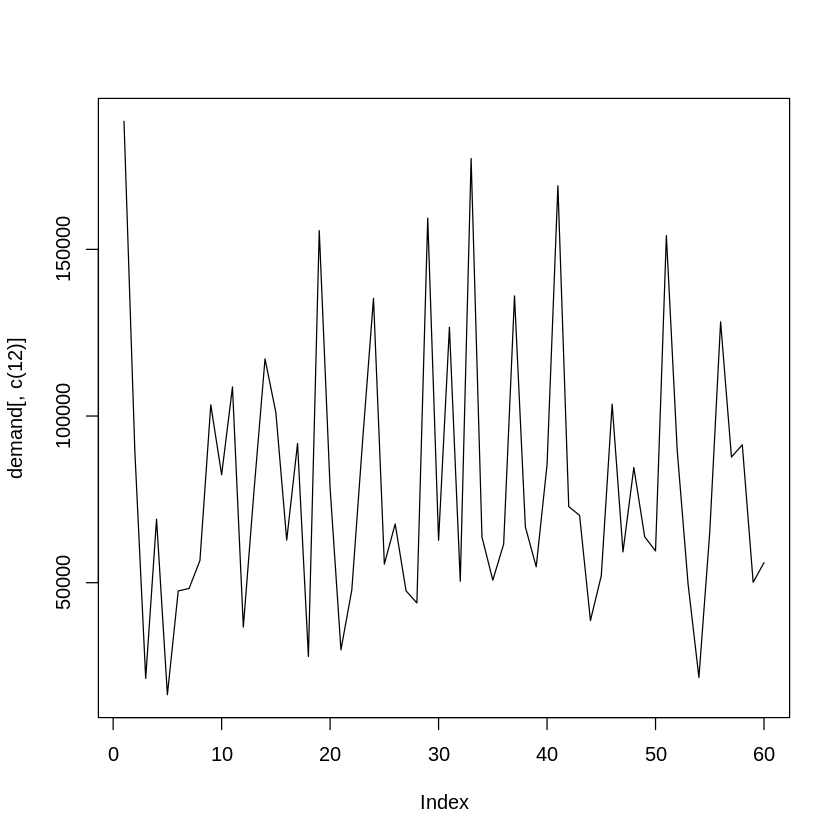

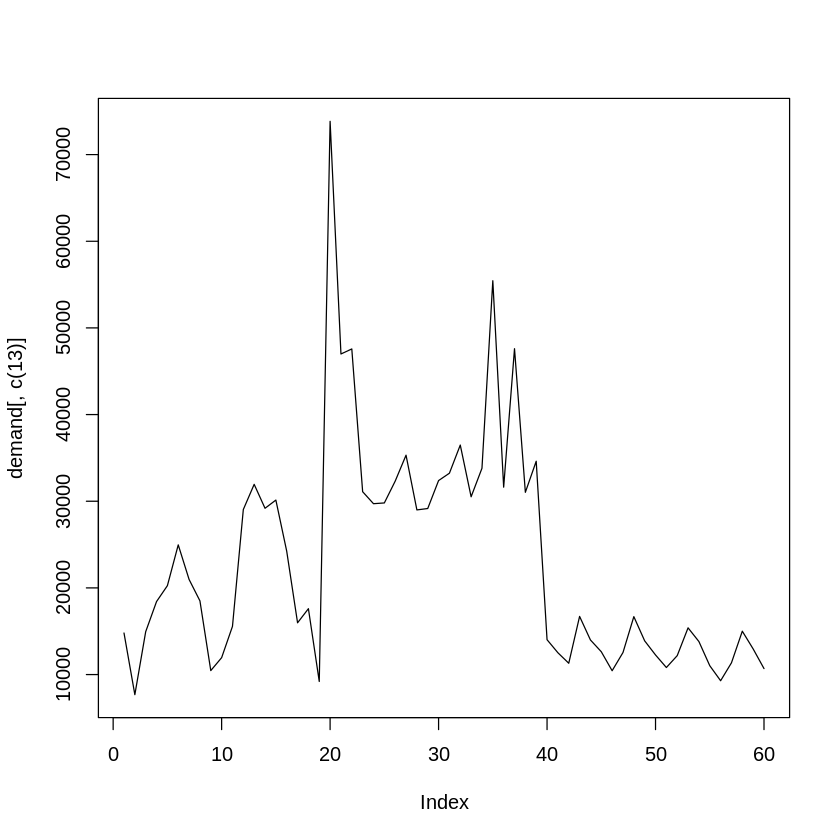

In [42]:
plot(demand[,c(12)], type = 'l')
plot(demand[,c(13)], type = 'l')

In [45]:
# install.packages("vars")
library(vars)

In [44]:
VARselect(demand[,9:10], lag.max = 4, type = "const")

,1,2,3,4
AIC(n),2.930307e+01,2.939625e+01,2.941938e+01,2.951627e+01
HQ(n),2.938720e+01,2.953647e+01,2.961568e+01,2.976867e+01
SC(n),2.952007e+01,2.975792e+01,2.992572e+01,3.016728e+01
FPE(n),5.324132e+12,5.848467e+12,5.995362e+12,6.625166e+12


In [46]:
# 시차는 3으로
est.var <- VAR(demand[,c(12,13)], p=3, type = "const")
est.var


VAR Estimation Results:

Estimated coefficients for equation Banking.orders..2.: 
Call:
Banking.orders..2. = Banking.orders..2..l1 + Banking.orders..3..l1 + Banking.orders..2..l2 + Banking.orders..3..l2 + Banking.orders..2..l3 + Banking.orders..3..l3 + const 

Banking.orders..2..l1 Banking.orders..3..l1 Banking.orders..2..l2 
        -2.134351e-01         -1.070454e+00         -3.332587e-02 
Banking.orders..3..l2 Banking.orders..2..l3 Banking.orders..3..l3 
         6.778114e-01         -2.378322e-01          8.626345e-01 
                const 
         1.055717e+05 


Estimated coefficients for equation Banking.orders..3.: 
Call:
Banking.orders..3. = Banking.orders..2..l1 + Banking.orders..3..l1 + Banking.orders..2..l2 + Banking.orders..3..l2 + Banking.orders..2..l3 + Banking.orders..3..l3 + const 

Banking.orders..2..l1 Banking.orders..3..l1 Banking.orders..2..l2 
         9.985195e-02          4.954869e-01          3.819053e-02 
Banking.orders..3..l2 Banking.orders..2..l3 Banking.

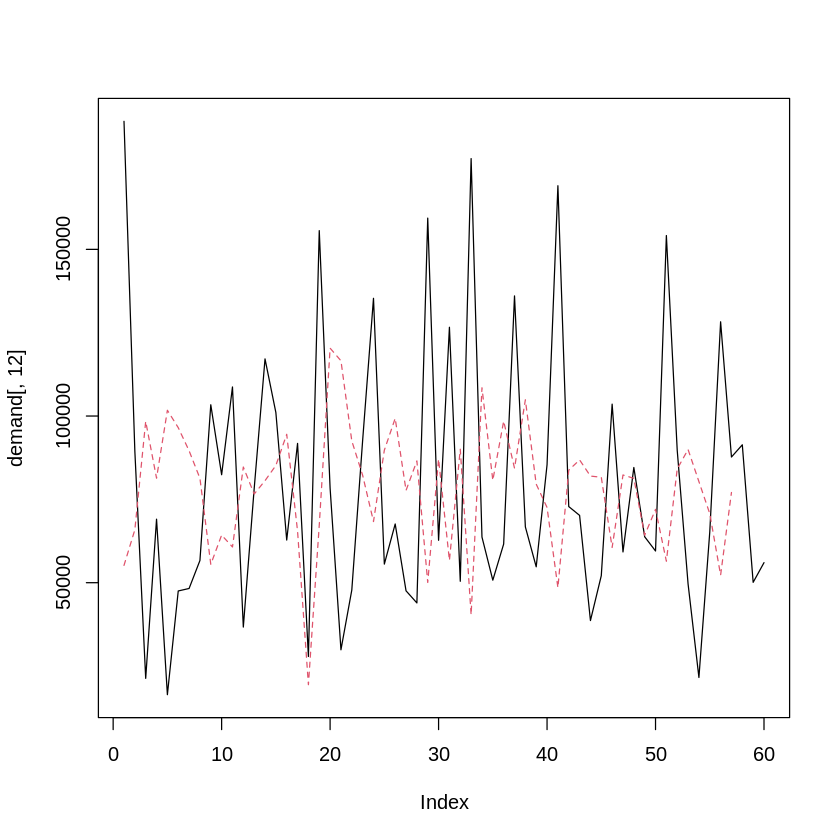

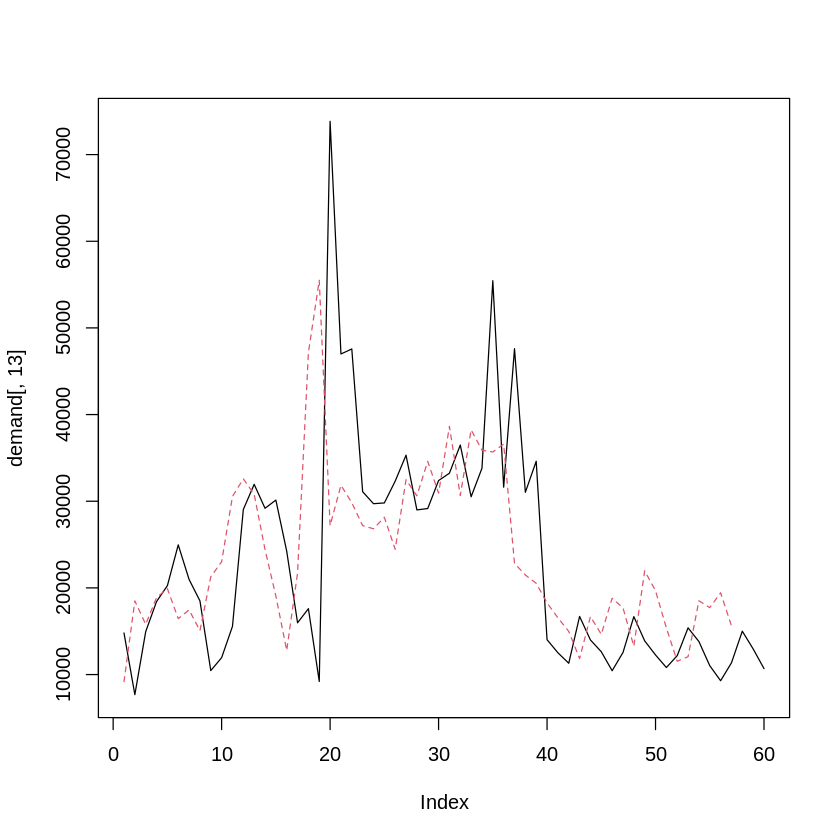

In [47]:
plot(demand[,12], type = "l")
lines(fitted(est.var)[,1], col =2, lty=2)

# Banking orders (3)
plot(demand[,13], type = "l")
lines(fitted(est.var)[,2], col =2, lty=2)

Warning message in demand[, 12] - fitted(est.var)[, 1]:
“longer object length is not a multiple of shorter object length”
Warning message in demand[, 13] - fitted(est.var)[, 2]:
“longer object length is not a multiple of shorter object length”


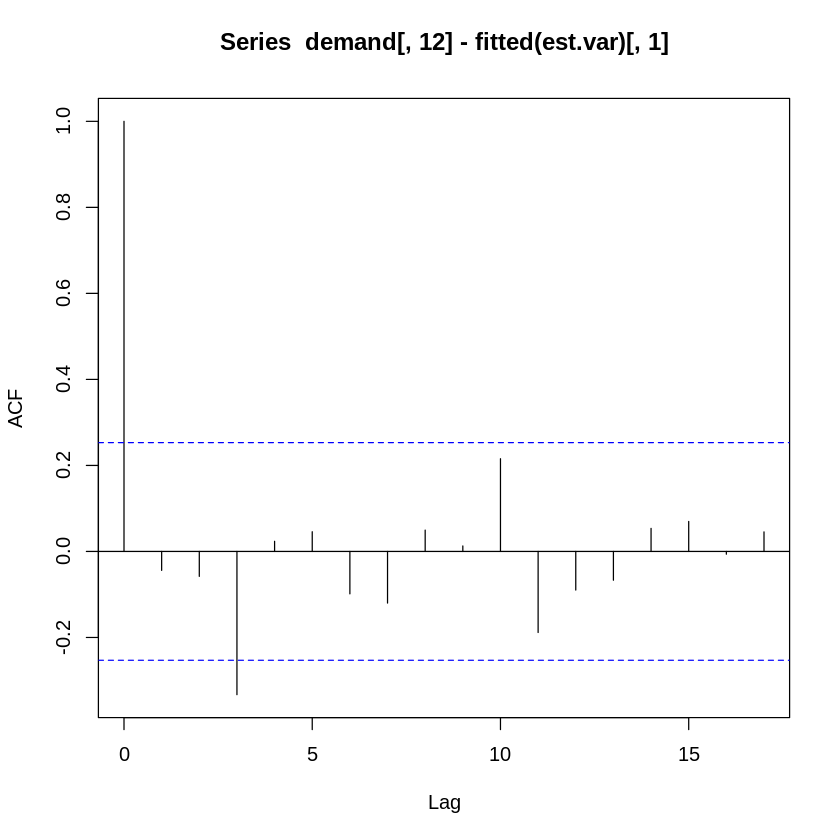

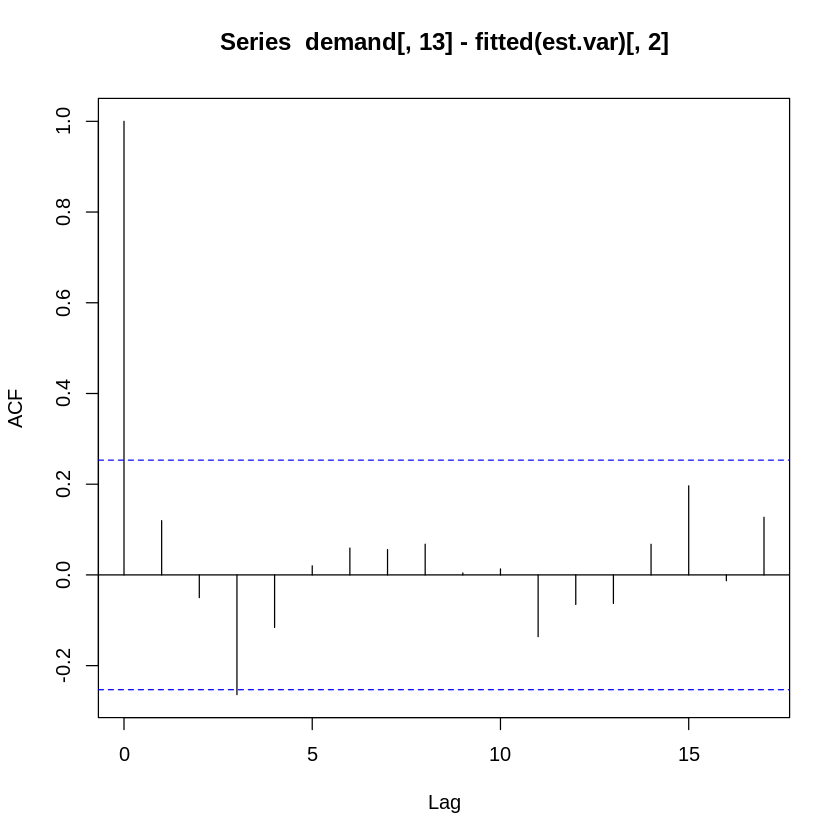

In [48]:
# Banking orders (2)
acf(demand[,12]-fitted(est.var)[,1])

# Banking orders (3)
acf(demand[,13]- fitted(est.var)[,2])

### 퍼트멘토 검정
* H0 : 잔차들의 시차가 1 이상인 모든 자기상관함수들은 0이다.
* H1 : not H0

In [49]:
serial.test(est.var, lags.pt=8, type = "PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object est.var
Chi-squared = 20.463, df = 20, p-value = 0.4293

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object est.var
Chi-squared = 20.463, df = 20, p-value = 0.4293



p-value가 매우 크기 때문에 귀무가설을 기각할 수 없다. 즉, 잔차들의 시차가 1 이상인 모든 자기상관함수들은 0이다.

이외에도 CVAR이 있다. CVAR은 공적분된 벡터 자기회귀를 줄인 용어로, 정상이 아닌 개별 시계열들을 차분 없이 선형조합시키면 정상이 되는 경우를 의미한다.

# chapter7 : 상태공간 모델

## 선형 가우스 모델에 적용되는 칼만 필터

### 코드로 표현한 칼만 필터

In [50]:
# 시간 단계를 100번 거친다.
ts.length <- 100

# 가속도 설정
a <- rep(0.5, ts.length)

# 위치와 속도는 0에서 시작
x <- rep(0, ts.length)
v <- rep(0, ts.length)
for (ts in 2:ts.length) {
  x[ts] <- v[ts-1] * 2 + x[ts-1] + 1/2 * a[ts-1] ^ 2
  x[ts] <- x[ts] + rnorm(1, sd = 20)  # 확률적 요소
  v[ts] <- v[ts-1] + 2 * a[ts-1]
}

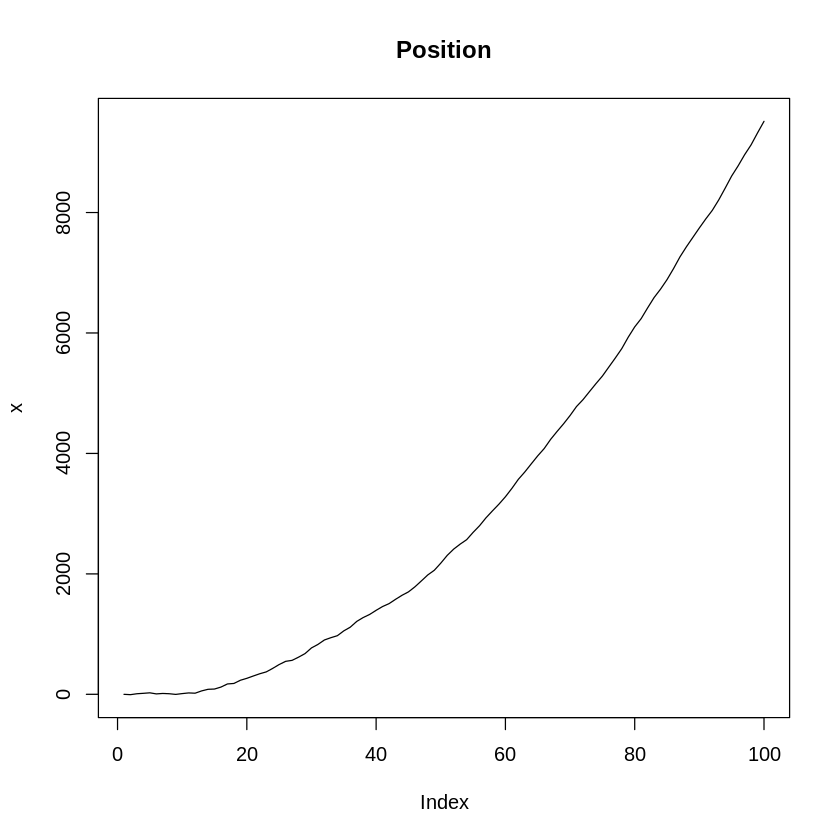

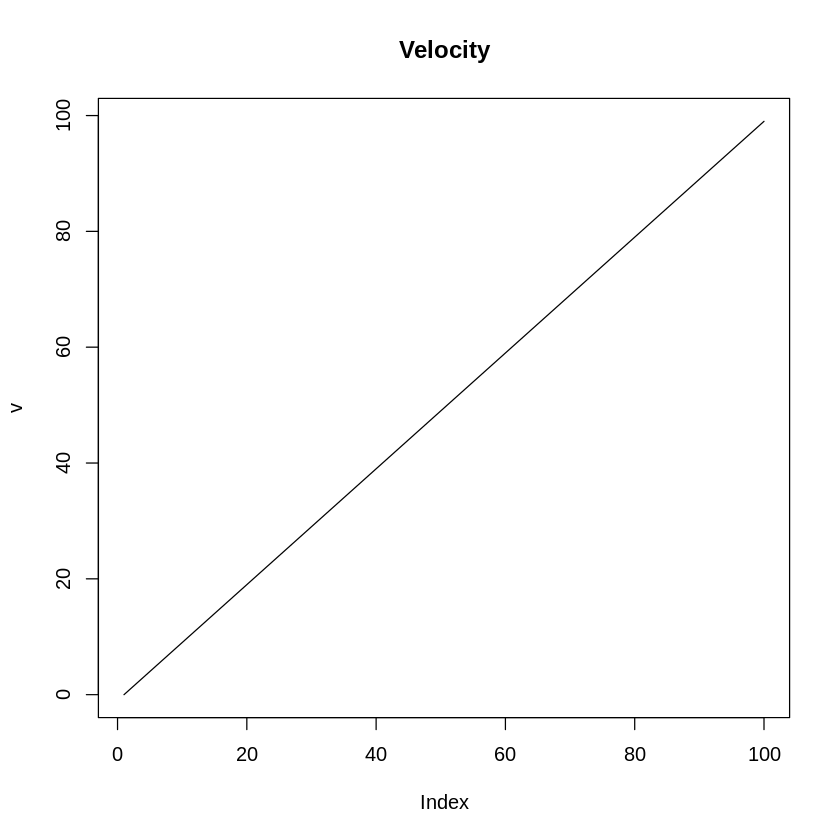

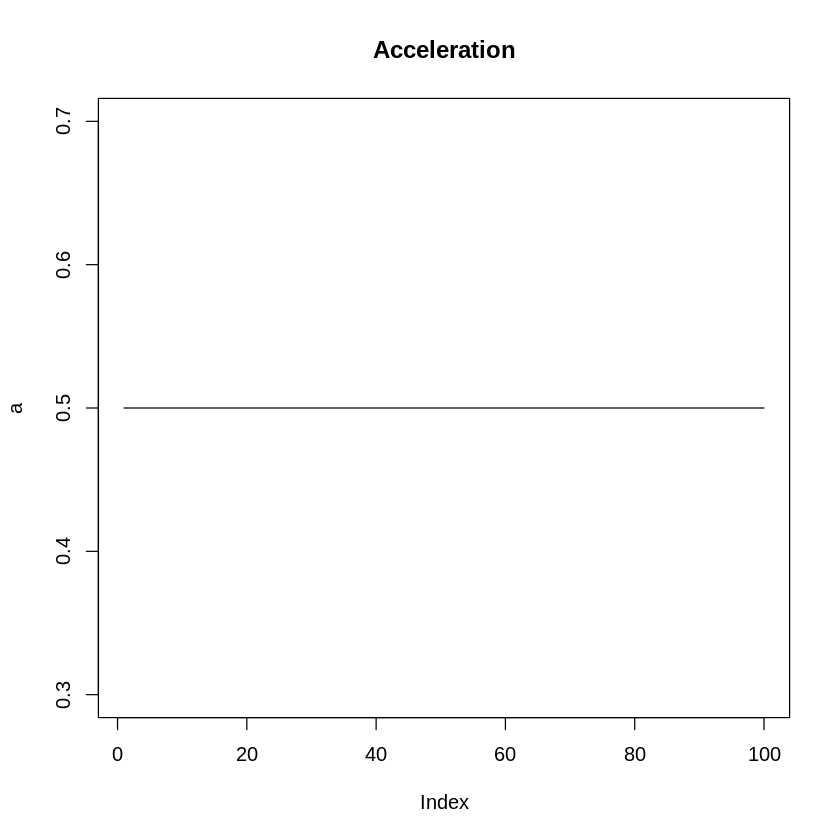

In [51]:
plot(x, main = "Position", type = "l")
plot(v, main = "Velocity", type = "l")
plot(a, main = "Acceleration", type = "l")

선형적으로 증가하는 속도(중간 그래프)에 영향을 주는 일정한 가속도(하단  그래프)가 결과적으로 위로 솟구치는 볼록한 그래프(상단 그래프)를 만들어 낸다 .

### 측정 값이 실제 위치와 어떤 관계를 갖는지에 대한 그래프

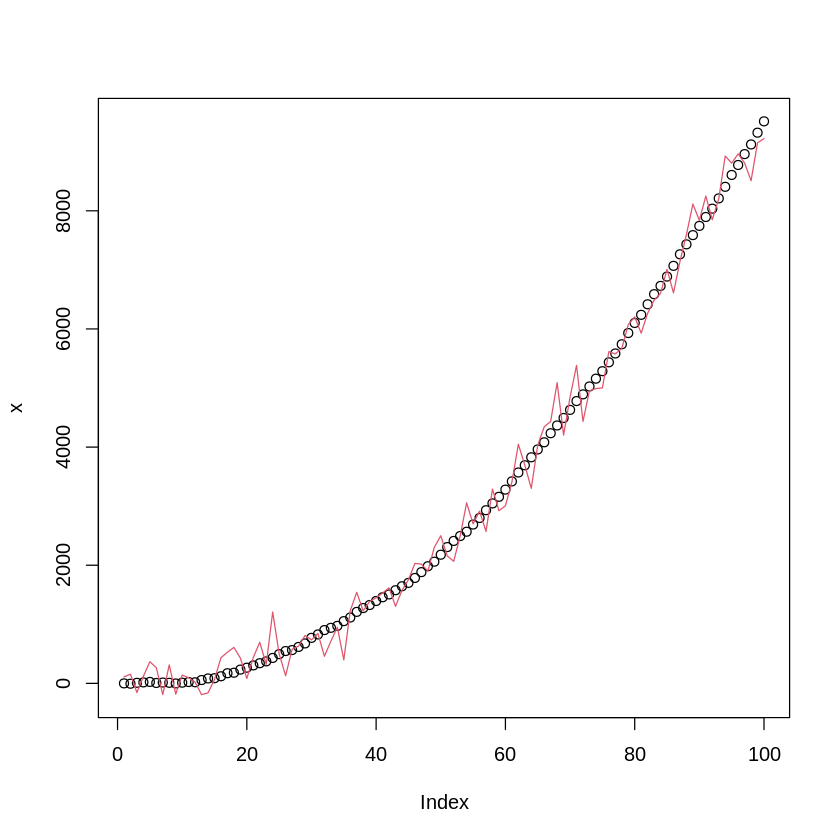

In [52]:
z <- x + rnorm(ts.length, sd = 300)
plot(x, ylim = range(c(x, z)))
lines(z, col = 2)

노이즈 때문에 측정 값이 완벽한 곡선을 그리지 않음.

### 칼만 필터 적용

In [53]:
kalmon.motion <- function(z, Q, R, A, H){
  dimState = dim(Q)[1]

  xhatminus <- array(rep(0, ts.length * dimState), c(ts.length, dimState)) # xhat의 inverse?
  xhat <- array(rep(0, ts.length * dimState), c(ts.length, dimState)) # xhat
  Pminus <- array(rep(0, ts.length * dimState * dimState), c(ts.length, dimState, dimState))
  P <- array(rep(0, ts.length * dimState * dimState), c(ts.length, dimState, dimState))
  K <- array(rep(0, ts.length * dimState), c(ts.length, dimState)) # 칼만 이득 K

  # 초기 추측
  xhat[1, ] <- rep(0, dimState)
  P[1, , ] <- diag(dimState)

  # 시간 갱신
  for (k in 2:ts.length){
    # 예측
    xhatminus[k, ] <- A %*% matrix(xhat[k-1, ])
    Pminus[k, , ] <- A %*% P[k-1, , ] %*% t(A) + Q
    # 필터링
    K[k, ] <- Pminus[k, , ] %*% H %*% solve(t(H) %*% Pminus[k, , ] %*% H + R)
    xhat[k, ] <- xhatminus[k, ] + K[k, ] %*% (z[k] - t(H) %*% xhatminus[k, ])
    P[k, , ] <- (diag(dimState)-K[k,] %*% t(H)) %*% Pminus[k, , ]
  }
  # 예측과 평활화된 값 모두 반환
  return(list(xhat = xhat, xhatminus = xhatminus))
}

In [54]:
# 노이즈 파라미터
R <- 10^2         # 측정의 분산
Q <- 10           # 과정의 분산

# 동적 파라미터
A <- matrix(1)    # x_t = A * x_t-1 (사전 x가 나중 x에 얼마나 영향을 미치는지)
H <- matrix(1)    # y_t = H * x_t (상태를 측정으로 변환)

# 칼만 필터 방법으로 데이터를 넣고 돌린다
xhat <- kalmon.motion(z, diag(1) * Q, R, A, H)[[1]]

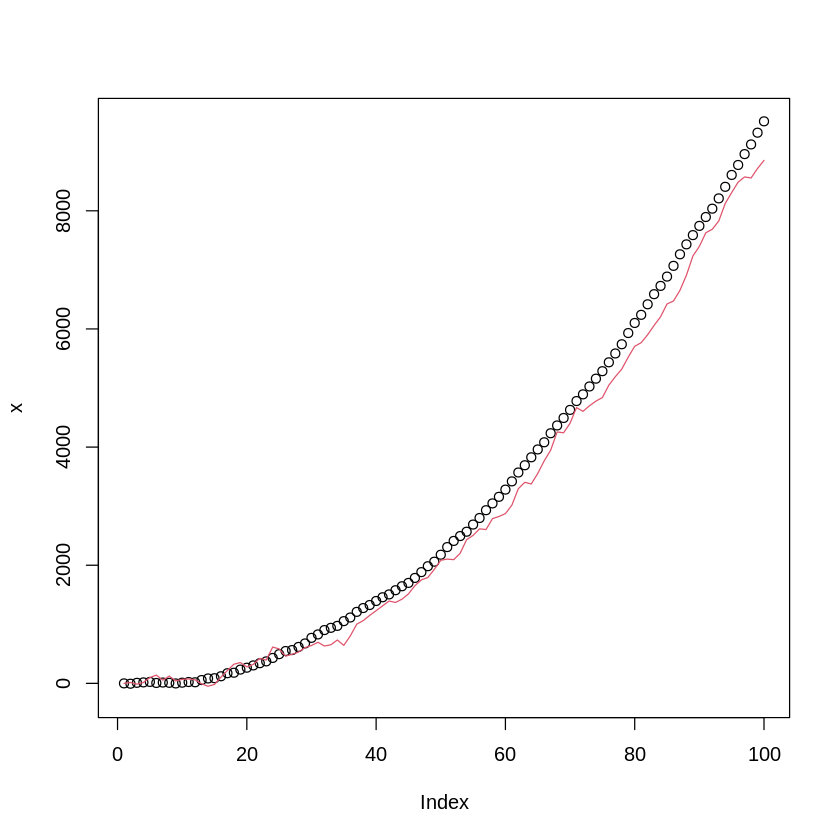

In [55]:
plot(x, ylim = range(c(x, z)))
lines(xhat, col = 2)

칼만 필터를 적용했더니, 노이즈로 인해 곡선을 그리지 못했던 부분이 개선됨.

## 은닉 마르코프 모형(HMM)

### 코드로 보는 HMM의 적합 과정

In [56]:
set.seed(123)

# 표현하려는 시장 상태 네 개에 대한 분포 파라미터 설정
bull_mu <- 0.1
bull_sd <- 0.1

neutral_mu <- 0.02
neutral_sd <- 0.08

bear_mu <- -0.03
bear_sd <- 0.2

panic_mu <- -0.1
panic_sd <- 0.3

# 위 파라미터를 벡터에 담는다
mus <- c(bull_mu, neutral_mu, bear_mu, panic_mu)
sds <- c(bull_sd, neutral_sd, bear_sd, panic_sd)

# 시계열이 생성할 내용에 대한 상수 설정
NUM.PERIODS <- 10
SMALLEST.PERIOD <- 20
LONGEST.PERIOD <- 40

# 확률적으로 일련의 일수(day, count)를 결정한다.
# 이때 각 일수는 한 번의 '실행' 또는 시장의 한 상탤르 나타낸다.
days <- sample(SMALLEST.PERIOD:LONGEST.PERIOD, NUM.PERIODS, replace = TRUE)

# days 벡터의 각 일수에 대해 특정 시장 상태를 가진 시계열을 생성하고, 이를 전체 시계열에 추가한다.
returns <- numeric()
true.mean <- numeric()

for (d in days) {
  idx = sample(1:4, 1, prob = c(0.2, 0.6, 0.18, 0.02))
  returns <- c(returns, rnorm(d, mean = mus[idx], sd = sds[idx]))
  true.mean <- c(true.mean, rep(mus[idx], d))
}


In [57]:
table(true.mean)

true.mean
-0.03  0.02   0.1 
   66   142   111 

In [58]:
# install.packages("depmixS4")

require(depmixS4)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘Rsolnp’


Loading required package: depmixS4

Loading required package: nnet

Loading required package: Rsolnp

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:forecast’:

    getResponse




In [59]:
hmm.model <- depmix(returns ~ 1, family = gaussian(),
                    nstates = 4, data = data.frame(returns = returns))
model.fit <- fit(hmm.model)
post_probs <- posterior(model.fit)

converged at iteration 357 with logLik: 265.7247 


Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


In [60]:
attr(model.fit, "response")

# [1] : bull과 가까움
# [2] : bear과 가까움
# [3] : panic과 가까움
# [4] : neutral과 가까움

[[1]]
[[1]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
 0.09774445 
sd  0.1040073 


[[2]]
[[2]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
 -0.0610505 
sd  0.2018184 


[[3]]
[[3]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
  0.1412881 
sd  0.03796197 


[[4]]
[[4]][[1]]
Model of type gaussian (identity), formula: returns ~ 1
Coefficients: 
(Intercept) 
0.001911518 
sd  0.05601123 



전 행렬을 사용하지 않았으므로, 은닉 상태와 잘 맞지 않는다.

## 베이즈 구조적 시계열

### [베이즈 구조적 시계열 설명](https://2stndard.tistory.com/15)